# 7. Orbit Distributions

In this notebook we'll take a closer look at orbit distributions. To run this notebook, you will already need to have created some models for the example galaxy NGC6278. To do this, first run the notebook `2_quickstart` and/or `3_quickstart`.

In [1]:
import dynamite as dyn

import numpy as np
import matplotlib.pyplot as plt

fname = 'NGC6278_config.yaml'
c = dyn.config_reader.Configuration(fname, reset_logging=True)

[INFO] 15:17:24 - dynamite.config_reader.Configuration - Config file NGC6278_config.yaml read.
[INFO] 15:17:24 - dynamite.config_reader.Configuration - io_settings...
[INFO] 15:17:24 - dynamite.config_reader.Configuration - Output directory tree: NGC6278_output/.
[INFO] 15:17:24 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 15:17:24 - dynamite.config_reader.Configuration - model_components...
[WARNING] 15:17:24 - dynamite.config_reader.Configuration - Kinematics califa: the 'weight' attribute is DEPRECATED and will be ignored. In a future DYNAMITE realease this will report an error.
[INFO] 15:17:24 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 15:17:24 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 15:17:24 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 15:17:24 - dynamite.config_reader.Configuration - Will attempt to recover partially run models.
[INFO] 15:17:24 - dynamite.config_reader.Config

In [2]:
dyn.__file__

'/opt/miniconda3/envs/dyn_new_install_test/lib/python3.12/site-packages/dynamite/__init__.py'

## 1. Get the dynamite `Model` object

First let's pick a model whose orbit distribution we want to construct. Let's look at a list of all models:

In [3]:
c.all_models.table

m-bh,a-bh,c-dh,f-dh,q-stars,p-stars,u-stars,ml,chi2,kinchi2,kinmapchi2,time_modified,orblib_done,weights_done,all_done,which_iter,directory
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str256,bool,bool,bool,int64,str256
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,5.0,34907.84446420323,15233.392153502471,20696.169017837754,2024-08-12T15:21:21.000,True,True,True,0,orblib_000_000/ml05.00/
100000.0,0.001,8.0,3.1622776601683795,0.54,0.99,0.9999,5.0,35682.09847852906,17517.598529097893,22587.232430597684,2024-08-12T15:21:21.000,True,True,True,1,orblib_001_000/ml05.00/
100000.0,0.001,8.0,31.622776601683793,0.54,0.99,0.9999,5.0,40381.260781702054,16672.465914841097,21903.107368108023,2024-08-12T15:21:21.000,True,True,True,1,orblib_001_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,1.0,501761.3369511359,364117.7844457637,188321.56299692756,2024-08-12T15:21:26.000,True,True,True,1,orblib_000_000/ml01.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,9.0,55644.286633037336,35706.52493641381,71919.5270590868,2024-08-12T15:21:26.000,True,True,True,1,orblib_000_000/ml09.00/
100000.0,0.001,8.0,5.623413251903491,0.54,0.99,0.9999,5.0,35926.57233355406,17047.546664927133,21696.381351773744,2024-08-12T15:22:44.000,True,True,True,2,orblib_002_000/ml05.00/
100000.0,0.001,8.0,17.78279410038923,0.54,0.99,0.9999,5.0,46948.23585666601,15331.098537218953,21104.46832974707,2024-08-12T15:22:45.000,True,True,True,2,orblib_002_001/ml05.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,3.0,78747.8191873637,53284.31304024356,48518.80332464653,2024-08-12T15:22:53.000,True,True,True,2,orblib_000_000/ml03.00/
100000.0,0.001,8.0,10.0,0.54,0.99,0.9999,7.0,36649.91832340149,18052.27305138151,36185.71281811051,2024-08-12T15:22:53.000,True,True,True,2,orblib_000_000/ml07.00/


Find the row index of the best model,

In [4]:
c.all_models.get_best_n_models_idx(1)

[12]

and then get a dynamite `Model` object corresponding to that row:

In [5]:
mod = c.all_models.get_model_from_row(12)
mod

Let's then load the orbit library and (already solved for) orbit weights for this model

In [6]:
orblib = mod.get_orblib()

weight_solver = mod.get_weights(orblib)
weights, _ , _, _= weight_solver.solve(orblib)

[INFO] 15:17:24 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 15:17:26 - dynamite.weight_solvers.NNLS - NNLS solution read from existing output
[INFO] 15:17:26 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 15:17:27 - dynamite.weight_solvers.NNLS - NNLS solution read from existing output


## 3. Orbit distribution plots

Let's run the plotting routine to make the orbit distribution plot:

[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 28.3% box
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 9.7% x-tubes
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 3.1% y-tubes
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 58.9% z-tubes
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 34.3% of x-tubes
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 9.1% of y-tubes
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary -     - 68.4% of z-tubes
[INFO] 15:17:27 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification DONE.
[INFO] 15:17:27 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 15:17:29 - dynamite.wei

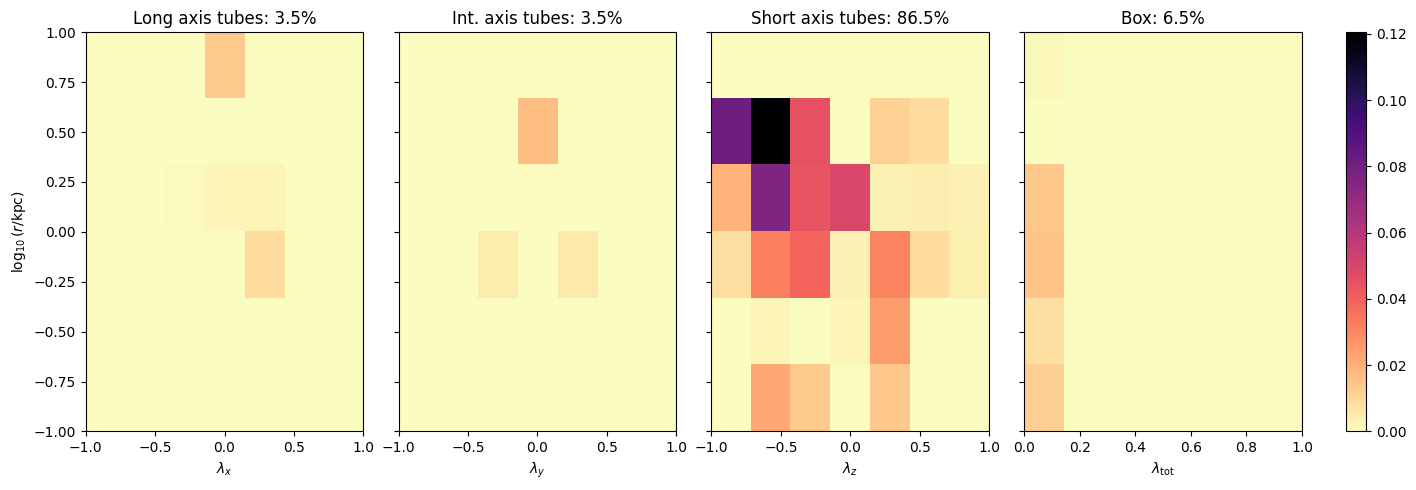

In [7]:
plotter = dyn.plotter.Plotter(c)

# defien settings
minr, maxr = 0.1, 10. # radius limits in kpc (to be binned in log r)
nr, nl = 6, 7 # use 6 bins in radius, 7 bins in circularity lambda

fig = plotter.orbit_distribution(mod, nr=nr, nl=nl, minr=minr, maxr=maxr) 

This plot shows the orbit-distributions split into four panels corresponding to four orbit-types. Each distribution shows a density in log radius (y-axis) against a circularity parameter $\lambda$ (x-axis). Which component of the circularity is shown depends on the orbit type:
- long-axis tube: $\lambda_x$
- intermediate-axis tube: $\lambda_y$
- short-axis tube: $\lambda_z$
- box: $\lambda_\mathrm{tot}$, using the total angular momentum (which should be zero for box orbits).

The main difference between this orbit-distribution plot and previous ones, which showed all orbit types in $(r,\lambda_z)$ space, is that by splitting by orbit-type we can distinguish long-axis tubes from box orbits. Restricting to $(r,\lambda_z)$ space overlays these two orbit-types since they both have $\lambda_z=0$. Intermediate-axis orbits are unstable, and therefore should form a negligible contribution; they are left in this plot mainly as a diagnostic for the orbit classification, more details of which are given below.

Finally, note that if you want to limit which orbit types are shown, you can use the `subset`keyword argument of `plotter.orbit_distribution` along with many other options to change its behaivour.

##  3. Recreating orbit distributions using `orblib.projection_tensor` 

To make the orbit distribution plot, when we call `plotter.orbit_distribution`, a method called `orblib.get_projection_tensor` is run internally. Let's run this ourselves in order to get access to the `orblib.projection_tensor` object which we can use to recreate the orbit distributions shown in the plots above:

In [8]:
orblib.get_projection_tensor(nr=nr, nl=nl, minr=minr, maxr=maxr)  # use same settings as before
orblib.projection_tensor

[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 28.3% box
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 9.7% x-tubes
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 3.1% y-tubes
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 58.9% z-tubes
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 34.3% of x-tubes
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 9.1% of y-tubes
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary -     - 68.4% of z-tubes
[INFO] 15:17:31 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification DONE.


Format,coo
Data Type,float64
Shape,"(4, 6, 7, 360)"
nnz,279
Density,0.004613095238095238
Read-only,True
Size,10.9K
Storage ratio,0.02


The `orblib.projection_tensor` is stored as a sparse object array to speed up some calculations. For simplicity, let's convert it to a regular `numpy` array using the `todense()` method:

In [9]:
projection_tensor = orblib.projection_tensor.todense()
projection_tensor.shape

(4, 6, 7, 360)

The `projection_tensor` has dimension 4 and shape (4, 6, 7, 360). These 4 dimensions correspond to:

- 4: orbit-types $t$ (long-axis tube, intermediate-axis tube, short-axis tube, box)
- 6: bins in radius $r$
- 7: bins in circularity (aka lambda) $l$
- 360: orbit bundles $b$

We'll refer to this tensor as $P_{trlb}$ where $(t,r,l,b)$ index over these four dimensions. $P_{trlb}$ is defined as the fraction of orbit bundle $b$ that is of orbit-type $t$ and that resides in radius bin $r$ and lambda bin $l$.

To demonstrate how we might use this object, say we want to know the fraction of different orbit-types per orbit-bundle. To do this, we can sum over all radius and lambda bins, 

In [10]:
orbit_fractions = np.sum(projection_tensor, (1,2))
orbit_fractions.shape

(4, 360)

then plot the resulting fractions:

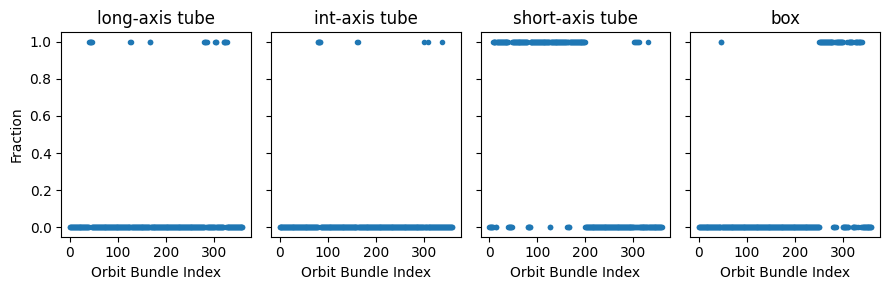

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(9,3), sharey=True)
titles = ['long-axis tube', 'int-axis tube', 'short-axis tube', 'box']
for i, (ax0, tit0) in enumerate(zip(ax, titles)):
    ax0.plot(orbit_fractions[i], '.')
    ax0.set_title(tit0)
    ax0.set_xlabel('Orbit Bundle Index')
ax[0].set_ylabel('Fraction')
fig.tight_layout()

In this test example (with dithering=1) each bundle is entirely made up of one orbit type i.e. all orbit fractions are 0 or 1. For dithering>1, note that this isn't the case: you can have orbit-bundles with mixtures of different types of orbits within them.

To get the orbit distributions in (radius, lambda) space, we take the dot product of the projection tensor with the orbit weights,

In [12]:
orbit_distributions = orblib.projection_tensor.dot(weights)
orbit_distributions.shape # (orbit types, radius bins, lambda bins)

(4, 6, 7)

We could then re-create the short-axis distribution plot as follows:

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/n2/qrrgr98x5flg7lx88y_r9z0r0000gn/T/ipykernel_71731/467479130.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.gca().set_xlabel('Circularity $\lambda_z$')


Text(0.5, 1.0, 'Short-axis tube distribution')

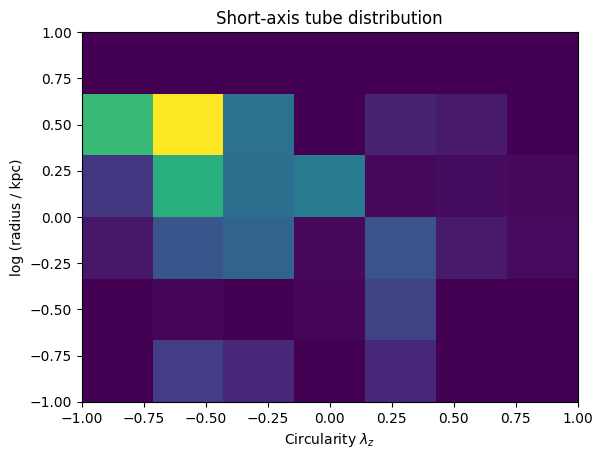

In [13]:
plt.imshow(
    orbit_distributions[2], # use index 2 for short axis tubes
    origin='lower', 
    extent=(-1, 1, np.log10(minr), np.log10(maxr)), 
    aspect='auto'
    )
plt.gca().set_xlabel('Circularity $\lambda_z$')
plt.gca().set_ylabel('log (radius / kpc)')
plt.gca().set_title('Short-axis tube distribution')

## 4. Orbit classification

To do the orbit classification, `orblib.get_projection_tensor` internally runs the method `orblib.classify_orbits`. To see what this does let's run this ourselves, now with the `make_diagnostic_plots` option set,

[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 28.3% box
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 9.7% x-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 3.1% y-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 58.9% z-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 34.3% of x-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 9.1% of y-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 68.4% of z-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification DONE.


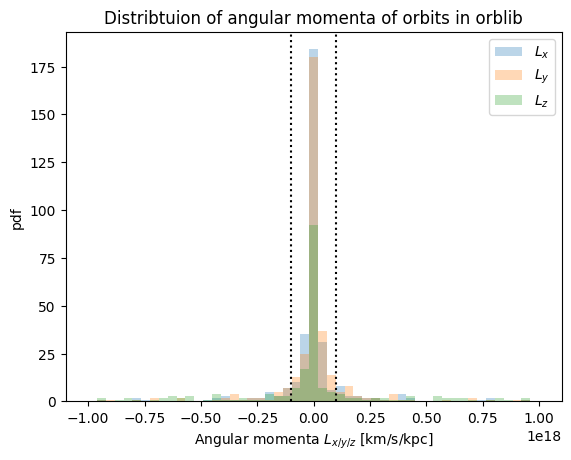

In [14]:
orblib.classify_orbits(make_diagnostic_plots=True)

This shows the distribution of angular momenta of the orbits in the orbit library. This is shown for the three components of angular momentum $(L_x, L_y, L_z)$ represented by the three coloured histrograms. The dotted vertical lines show a threshold angular momentum $dL$ which is used for orbit classification. By default, this is set to a (somewhat arbitrary!) choice of $dL= 10^17$.

Given this choice of $dL$, the classification is done as follows:
- if $L_x < dL$, $L_y < dL$ and $L_z < dL$, then it's a box orbit 
- otherwise, it's a tube orbit, with the largest component of $L$ determining the axis (e.g. if $L_z$ is largest then it's a short-axis tube orbit)

In theory, for tube-orbits we expect one and only one component of the time-averaged angular momentum to be non-zero. The output which is printed when we ran `orblib.classify_orbits` tells us what fraction of tube-orbits this is actually true for, when $dL$ is used as a threshold for "non-zero". Copying the relevant lines here:

```
[INFO] 14:02:01 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 14:02:01 - dynamite.orblib.LegacyOrbitLibrary -     - 34.3% of x-tubes
[INFO] 14:02:01 - dynamite.orblib.LegacyOrbitLibrary -     - 9.1% of y-tubes
[INFO] 14:02:01 - dynamite.orblib.LegacyOrbitLibrary -     - 68.4% of z-tubes
```

e.g. this says that only 68% of orbits we have classified as short-axis tubes have both $L_x<dL$ and $L_y$ below $dL$.

You may need to play around with the threshold $dL$ for your particular situation. This can be done by passing optional `dL` keyword to any of:
- `plotter.orbit_distribution`
- `orblib.get_projection_tensor`
- `orblib.classify_orbits`
e.g. if we increase it from the default value of $10^{17}$ to $3x\times10^{17}$, then the orbit distrubution changes as follows,

[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 34.7% box
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 8.6% x-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 2.5% y-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 54.2% z-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 51.6% of x-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 11.1% of y-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary -     - 83.6% of z-tubes
[INFO] 15:17:32 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification DONE.
[INFO] 15:17:32 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 15:17:33 - dynamite.we

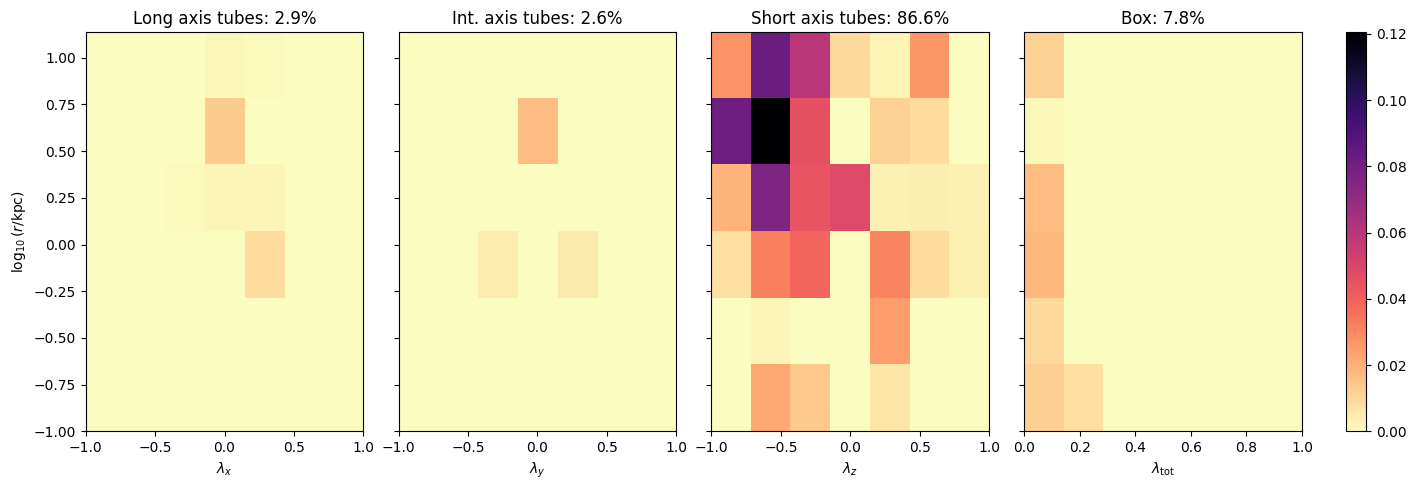

In [15]:
fig = plotter.orbit_distribution(mod, nr=nr, nl=nl, minr=minr, dL=3e17)

and we see that the box orbit fraction has increased from 6.5% earlier to 7.8% now.

## 5. Viewing the "combined" orbit-distribution in $(r, $\lambda_z$)$ space

We also have the option to see the "combined" orbit-distribution, where all orbits are shown in $(r, $\lambda_z)$ space regardless of their classification, by setting the `force_lambda_z` option to `True`:

[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% box
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% x-tubes
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% y-tubes
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary -     - 100.0% z-tubes
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
/opt/miniconda3/envs/dyn_new_install_test/lib/python3.12/site-packages/dynamite/orblib.py:1281: RuntimeWarning: divide by zero encountered in scalar divide
  self.logger.info(f'    - {percent(n_xt_exact/n_xtish)} of x-tubes')
[INFO] 15:17:35 - dynamite.orblib.LegacyOrbitLibrary -     - inf% of x-tubes
/opt/miniconda3/envs/dyn_new_install_test/lib/python3.12/site-packages/dynamite/orblib.py:1282: RuntimeWarning: divide by zero enc

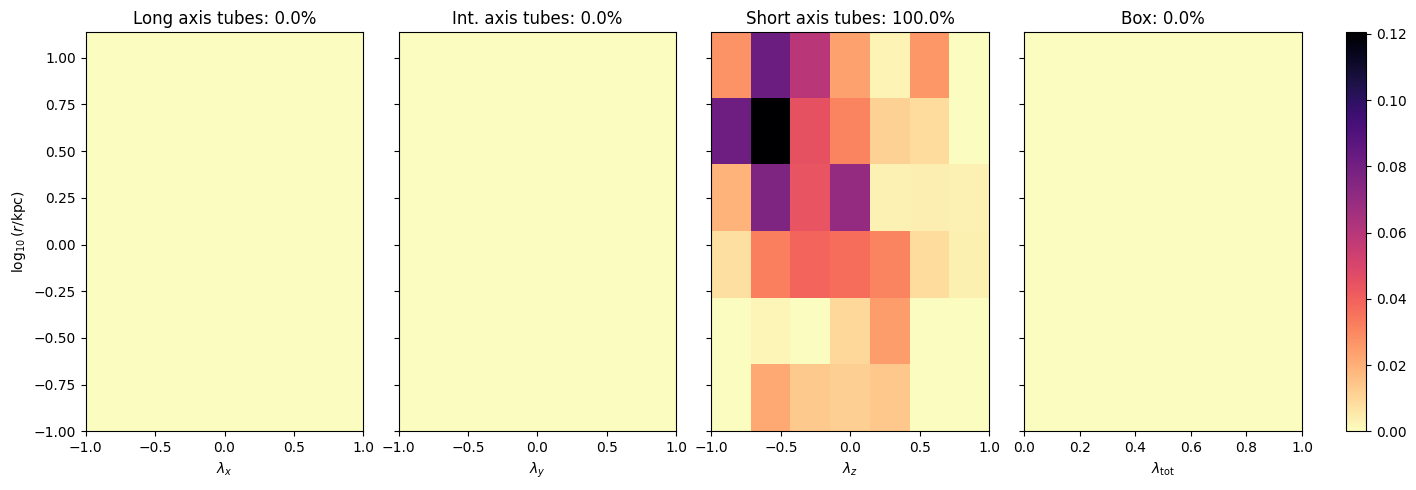

In [16]:
fig = plotter.orbit_distribution(mod, nr=nr, nl=nl, minr=minr, force_lambda_z=True)

Now all orbits are treated as short-axis tube orbits and shown in the third panel, with $\lambda_z$ on the x-axis. If we wanted to show *only* this third panel, in the more familiar orientation where circularity is on the y-axis, we can do so as follows:

[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% box
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% x-tubes
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% y-tubes
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - 100.0% z-tubes
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - inf% of x-tubes
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - inf% of y-tubes
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary -     - 40.3% of z-tubes
[INFO] 15:17:38 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification DONE.
[INFO] 15:17:38 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 15:17:39 - dynamite.weig

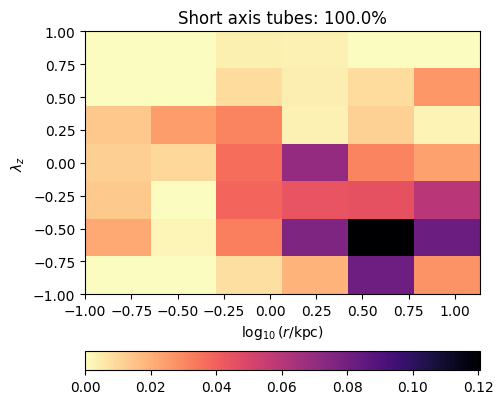

In [17]:
fig = plotter.orbit_distribution(
    mod, nr=nr, nl=nl, minr=minr,
    force_lambda_z=True, subset='short', orientation='vertical'
    )

Warning: when using `force_lambda_z=True`, then the titles of the orbit-distribution plots are incorrect. All orbits are shown in this distribution - not only short-axis tubes!

As before, if we wanted to reconstruct this orbit distribution for use in other analysis, then we run `get_projection_tensor` except now setting the `force_lambda_z` setting to True. This forces the classification to (incorrectly) identify all orbits as short-axis tubes in the `projection_tensor`, e.g. if we re-create the orbit-type fraction plot from earlier,

[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification:
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% box
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% x-tubes
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% y-tubes
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - 100.0% z-tubes
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - 0.0% other types
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary - Amongst tubes, % with only one nonzero component of L:
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - inf% of x-tubes
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - inf% of y-tubes
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary -     - 40.3% of z-tubes
[INFO] 15:17:40 - dynamite.orblib.LegacyOrbitLibrary - Orbit library classification DONE.


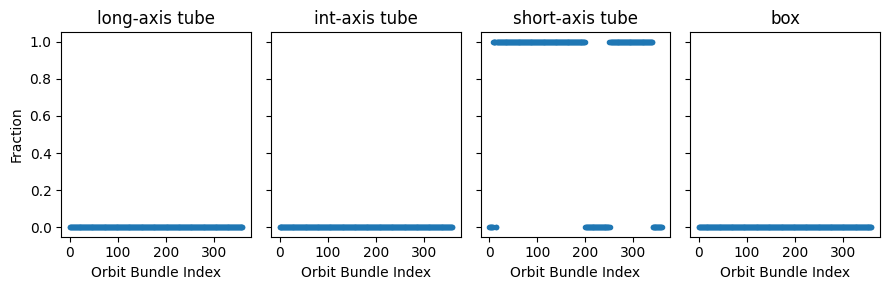

In [18]:
orblib.get_projection_tensor(nr=nr, nl=nl, minr=minr, maxr=maxr, force_lambda_z=True) 
projection_tensor = orblib.projection_tensor.todense()

orbit_fractions = np.sum(projection_tensor, (1,2))

fig, ax = plt.subplots(1, 4, figsize=(9,3), sharey=True)
titles = ['long-axis tube', 'int-axis tube', 'short-axis tube', 'box']
for i, (ax0, tit0) in enumerate(zip(ax, titles)):
    ax0.plot(orbit_fractions[i], '.')
    ax0.set_title(tit0)
    ax0.set_xlabel('Orbit Bundle Index')
ax[0].set_ylabel('Fraction')
fig.tight_layout()

We see that (almost) all orbits are classified as short-axis tubes. Note that there are some orbits which have orbit fraction = 0 for all four orbit types. This has happened because of our choice of radial range - these orbits do not enter this range. We could include all orbits by decreasing `minr` and increasing `maxr`.